In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import data_preprocessing as dp
import utilities
import models.training as train


In [2]:
data, events = dp.load_data(subjects=range(1,11))
data, events = dp.choose_condition(data, events, 'inner speech')

### Paramters

In [95]:
train_size = 0.8
test_size = 0.1
valid_size = 0.1
explained_var = 0.95

### Functions:
 - plot original and reconstructed pca data
 - plot PCA
 - Plot difference between original and PCA reconstruction


In [4]:
def side_by_side(original, reconstructed, indexes):
    org = original[indexes]
    rec = reconstructed[indexes]
    middle = np.zeros((org.shape[0],20))
    pair = np.concatenate((org, middle), axis=1)
    pair = np.concatenate((pair, rec), axis=1)
    plt.figure(figsize=(16,14))
    plt.imshow(pair, cmap='viridis')
    plt.title('Before and after pca')
    plt.show()

In [38]:
def pca_pic(pca_data, index, dim = 1):
    plt.figure(figsize= (8 ,6))
    if dim != 1:
        plt.imshow(pca_data[index])
    else:
        plt.plot(pca_data[index])
    plt.title('PCA data')
    plt.show()

In [39]:
def difference(original, reconstructed, indexes):
    org = original[indexes]
    rec = reconstructed[indexes]
    diff = org-rec
    plt.figure(figsize=(8,7))
    plt.imshow(diff)
    plt.title('Difference: Before- after')
    plt.show()

In [40]:
def split_dataset(ds, split_proportions = {
    'train': 0.8,
    'valid': 0.1,
    'test': 0.1}):
  assert sum(split_proportions.values()) <= 1,\
      "The sum of split_proportions is larger than 1!"
  ds_len = len(list(ds))
  split_dataset = {}
  start = 0
  for key, value in split_proportions.items():
    samples = int(ds_len*value)
    split_dataset[key] = ds[start:start+samples]
    start +=samples
  return split_dataset


### Data preparation:
filter relevant interval


In [30]:
f_data = dp.filter_interval(data, [1,3.5],256)

Standardize

In [31]:
#standardize data
scaler = StandardScaler()
s_data = scaler.fit_transform(f_data.reshape(-1, f_data.shape[-1])).reshape(f_data.shape)

### Create PCA datasets

In [45]:
# reshape version
rf_data = s_data.reshape(len(s_data), 128*640)
rf_split = split_dataset(rf_data)
# mean version
split = split_dataset(s_data)
mean_data = np.mean(split['train'], axis = 0)

### Fit and apply PCA:
Fit and apply on reshaped data

In [118]:
# fit and apply on reshaped data
pca_1 = PCA(n_components=explained_var)
rf_pca = pca_1.fit(rf_split['train'])
rf_pca_ds = {}
for key in rf_split:
    rf_pca_ds[key] = pca_1.transform(rf_split[key])



Shape before PCA:  (1660, 81920)
Shape after PCA:  (1660, 756)


Text(0.5, 1.0, 'PCA on reshaped EEG data')

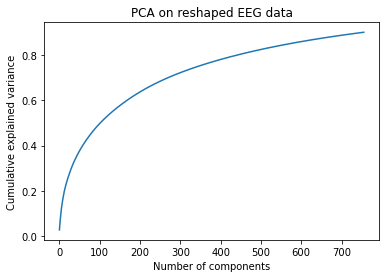

In [119]:
# print shapes before and after pca
print("Shape before PCA: ", rf_split['train'].shape)
print("Shape after PCA: ", rf_pca_ds['train'].shape)

# plot explained variance by n components
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("PCA on reshaped EEG data")

In [35]:
# reverse pca
inv_rf_pca = pca_1.inverse_transform(rf_pca_ds['train'])
inv_rf = [scaler.inverse_transform(elem.reshape(128, 640)) for elem in inv_rf_pca]
inv_rf_pca_valid = pca_1.inverse_transform(rf_pca_ds['valid'])
inv_rf_valid = [scaler.inverse_transform(elem.reshape(128, 640)) for elem in inv_rf_pca_valid]

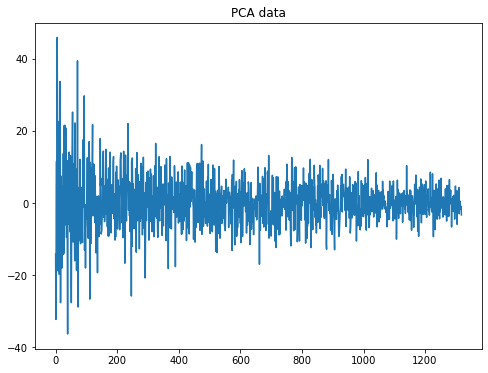

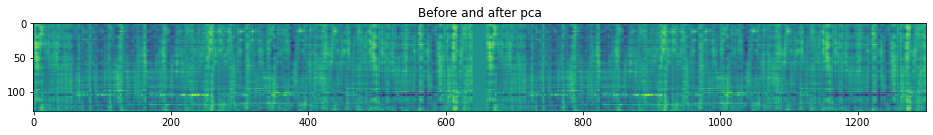

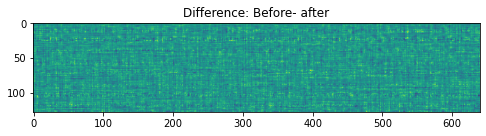

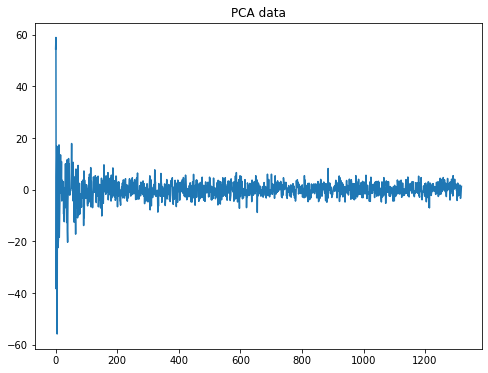

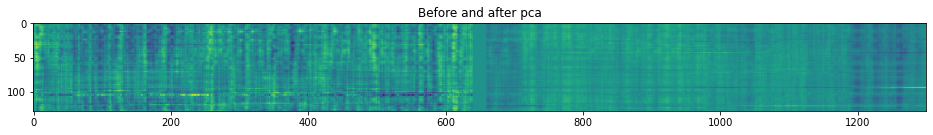

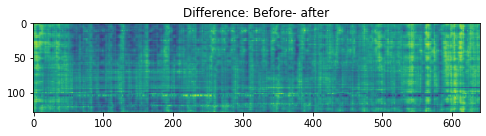

In [43]:
# plot results
for elem in range(1):
    pca_pic(rf_pca_ds['train'], elem)
    side_by_side(f_data, inv_rf,elem)
    difference(f_data, inv_rf,elem)

    pca_pic(rf_pca_ds['valid'], elem)
    side_by_side(f_data, inv_rf_valid,elem)
    difference(f_data, inv_rf_valid,elem)

fit on mean data, applied on time dimension

In [104]:
# fit on mean data, applied on time dimension
pca_2 = PCA(n_components=explained_var)
pca_2.fit(mean_data)
mean_time_pca = {}
for key in split:
    mean_time_pca[key] = [pca_2.transform(elem) for elem in split[key]]


Shape before PCA:  (128, 640)
Shape after PCA:  (128, 5)


Text(0.5, 1.0, 'PCA based on mean EEG data for time dimension')

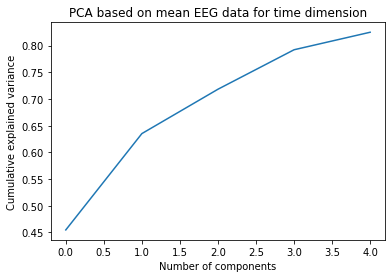

In [105]:
# print shapes before and after pca
print("Shape before PCA: ", mean_data.shape)
print("Shape after PCA: ", mean_time_pca['train'][0].shape)

# plot explained variance by n components
plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("PCA based on mean EEG data for time dimension")

In [60]:
# reverse pca
inv_mean_time_pca = [pca_2.inverse_transform(elem) for elem in mean_time_pca['train']]
inv_mean_time= [scaler.inverse_transform(elem) for elem in inv_mean_time_pca]
inv_mean_time_pca_valid = [pca_2.inverse_transform(elem) for elem in mean_time_pca['valid']]
inv_mean_time_valid= [scaler.inverse_transform(elem) for elem in inv_mean_time_pca_valid]

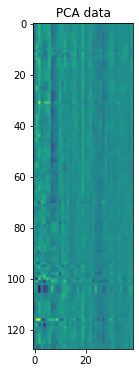

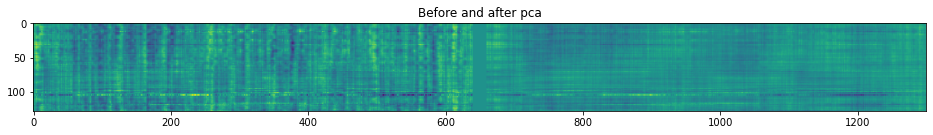

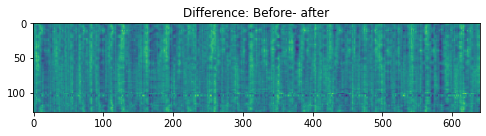

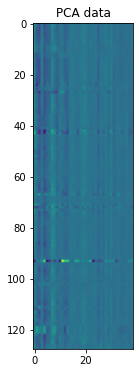

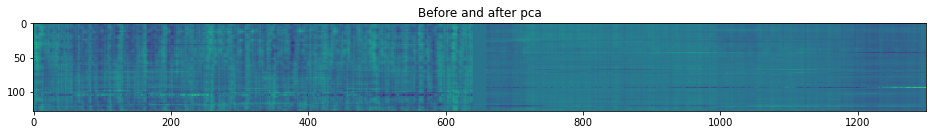

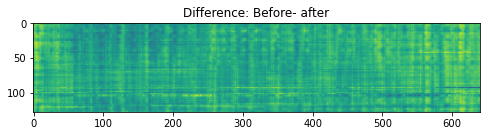

In [62]:
# plot results
for elem in range(1):
    pca_pic(mean_time_pca['train'], elem, dim = 2)
    side_by_side(f_data, inv_mean_time,elem)
    difference(f_data, inv_mean_time,elem)
    pca_pic(mean_time_pca['valid'], elem, dim = 2)
    side_by_side(f_data, inv_mean_time_valid,elem)
    difference(f_data, inv_mean_time_valid,elem)

fit on transposed mean data, applied on channel dimension

In [112]:
# fit on transposed mean data, applied on channel dimension
pca_3 = PCA(n_components=explained_var)
pca_3.fit(mean_data.T)
mean_channel_pca = {}
for key in split:
    mean_channel_pca[key] = [pca_3.transform(elem.T).T for elem in split[key]]



Shape before PCA:  (128, 640)
Shape after PCA:  (26, 640)


Text(0.5, 1.0, 'PCA on reshaped EEG data for channel dimension')

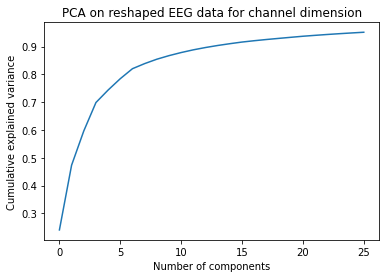

In [113]:
# print shapes before and after pca
print("Shape before PCA: ", mean_data.shape)
print("Shape after PCA: ", mean_channel_pca['train'][0].shape)

# plot explained variance by n components
plt.plot(np.cumsum(pca_3.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("PCA on reshaped EEG data for channel dimension")

In [58]:
# reverse pca
inv_mean_channel_pca = [pca_3.inverse_transform(elem.T).T for elem in mean_channel_pca['train']]
inv_mean_channel= [scaler.inverse_transform(elem) for elem in inv_mean_channel_pca]
inv_mean_channel_pca_valid = [pca_3.inverse_transform(elem.T).T for elem in mean_channel_pca['valid']]
inv_mean_channel_valid= [scaler.inverse_transform(elem) for elem in inv_mean_channel_pca_valid]

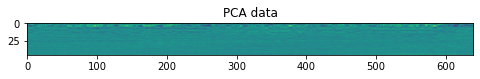

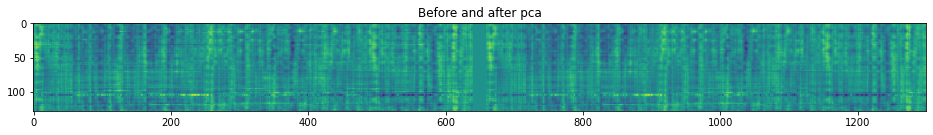

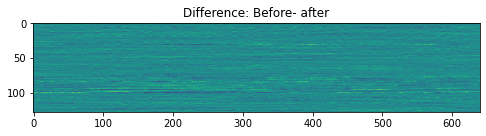

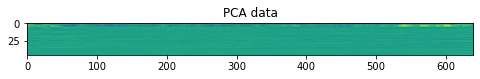

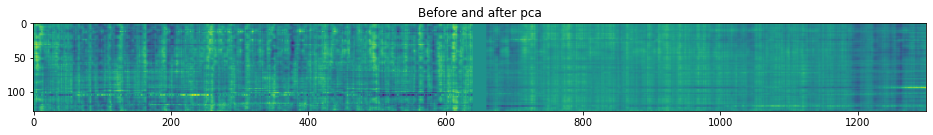

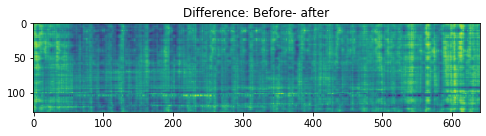

In [59]:
# plot results
for elem in range(1):
    pca_pic(mean_channel_pca['train'], elem, dim = 2)
    side_by_side(f_data, inv_mean_channel,elem)
    difference(f_data, inv_mean_channel,elem)

    pca_pic(mean_channel_pca['valid'], elem, dim = 2)
    side_by_side(f_data, inv_mean_channel_valid,elem)
    difference(f_data, inv_mean_channel_valid,elem)

### Create Tensorflow dataset

In [64]:
pca_comp = rf_pca_ds['train'].shape[1]
print(pca_comp)
e_split = split_dataset(events[:,1])
print(e_split.keys())

1319
dict_keys(['train', 'valid', 'test'])


In [80]:
rf_dataset = {key:tf.data.Dataset.from_tensor_slices((rf_pca_ds[key], e_split[key])) for key in rf_pca_ds}

In [93]:
rf_datasets = {key:dp.preprocessing_pipeline(
    ds,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4))#, # one-hot
                 #lambda sample: (tf.reshape(sample[0], (pca_comp, 1, 1)),
                                 #sample[1])
                 ],
    args = [[]],
    batch_size = 12
)for key, ds in rf_dataset.items()}


In [82]:
time_dataset = {key:tf.data.Dataset.from_tensor_slices((mean_time_pca[key], e_split[key])) for key in mean_time_pca}

In [83]:
time_datasets ={ key:dp.preprocessing_pipeline(
    ds,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                lambda sample: (tf.reshape(sample[0],(*sample[0].shape, 1)), sample[1])],
    args = [[], []],
    batch_size = 12
) for key, ds in time_dataset.items()}


In [84]:
channel_dataset = {key:tf.data.Dataset.from_tensor_slices((mean_channel_pca[key], e_split[key])) for key in mean_channel_pca}

In [86]:
channel_datasets = {key: dp.preprocessing_pipeline(
    ds,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                lambda sample: (tf.reshape(sample[0],(*sample[0].shape, 1)), sample[1])],
    args = [[], []],
    batch_size = 12
) for key, ds in channel_dataset.items()}


### save datasets

In [94]:
# save dataset so that we can just load the preprocessed version next time
for key in ('train', 'test', 'valid'):
    tf.data.experimental.save(rf_datasets[key],
                              f'dataset/preprocessed/reshaped_pca{explained_var}train_ds/'
                              f'{key}')
    tf.data.experimental.save(time_datasets[key],
                              f'dataset/preprocessed/time_pca{explained_var}train_ds/'
                              f'{key}')
    tf.data.experimental.save(channel_datasets[key],
                              f'dataset/preprocessed/channel_pca{explained_var}train_ds/'
                              f'{key}')